In [1]:
run runAll

20211207_10_MPA_STD_01.txt
20211207_11_MPA_A_01.txt
20211207_12_MPA_STD_02.txt
20211207_13_MPA_A_02.txt
20211207_14_MPA_STD_03.txt
20211207_15_MPA_A_03.txt
20211207_16_MPA_STD_04.txt
20211207_17_MPA_F_01.txt
20211207_18_MPA_STD_05.txt
20211207_19_MPA_F_02.txt
20211207_20_MPA_STD_06.txt
20211207_21_MPA_F_03.txt
20211207_22_MPA_STD_07.txt
20211208_11_MPA_STD_01.txt
20211208_12_MPA_K_01.txt
20211208_13_MPA_STD_02.txt
20211208_14_MPA_K_02.txt
20211208_15_MPA_STD_03.txt
20211208_16_MPA_K_03.txt
20211208_17_MPA_STD_04.txt
20211208_18_MPA_I_01.txt
20211208_19_MPA_STD_05.txt
20211208_20_MPA_I_02.txt
20211208_21_MPA_STD_06.txt
20211208_22_MPA_I_03.txt
20211208_23_MPA_STD_04.txt
20211209_05_MPA_STD_01.txt
20211209_06_MPA_M_01.txt
20211209_07_MPA_STD_02.txt
20211209_08_MPA_M_02.txt
20211209_09_MPA_STD_03.txt
20211209_10_MPA_M_03.txt
20211209_11_MPA_STD_04.txt
20211210_09_MPA_STD_01.txt
20211210_10_MPA_C_01.txt
20211210_11_MPA_STD_01_Repeat.txt
20211210_12_MPA_C_02.txt
20211210_13_MPA_STD_03.txt
2

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

checkThresholdConstant = False
if checkThresholdConstant:
    maxes = []
    for i in tqdm(range(1000)):
        array = np.random.normal(size = 4570)

        # Reshape the array into a 2D array with 10 columns
        num_rows = 4570 // 10
        reshaped_array = array[:num_rows * 10].reshape(num_rows, 10)

        # Calculate the average along axis 1 (columns)
        averages = np.mean(reshaped_array, axis=1)

        outlier = dataScreen_FTStat.subsequenceOutlierDetection(pd.Series(averages), priorSubsequenceLength = 100, testSubsequenceLength = 100)
        maxes.append(outlier.max())

    np.array(maxes).mean() + 4 * np.array(maxes).std()

In [3]:
checkTIC = False
if checkTIC:
    for thisSmp in ['A','F','K','I','M','C']:
        firstIdx = SmpStd.index(thisSmp)
        thisSmpIndices = [firstIdx, firstIdx + 2, firstIdx + 4]
        thisStdIndices = [firstIdx-1, firstIdx +1, firstIdx + 3, firstIdx +5]

        allSmpTic = []
        for smpIdx in thisSmpIndices:
            smpName = list(mergedDict.keys())[smpIdx]
            thisDf = mergedList[smpName][0]
            allSmpTic += list(thisDf['tic'])

        allStdTic = []
        for stdIdx in thisStdIndices:
            stdName = list(mergedDict.keys())[stdIdx]
            thisDf = mergedDict[stdName][0]
            allStdTic += list(thisDf['tic'])

        smpTic = np.array(allSmpTic)
        stdTic = np.array(allStdTic)
        print(thisSmp + ' ' + f'{smpTic.mean():.2f}' + ' ' + f'{smpTic.std() / smpTic.mean():.2f}')
        print( f'{stdTic.mean():.2f}' + ' ' + f'{stdTic.std() / stdTic.mean():.2f}')

In [12]:
processedResults = {}

fileList = list(sampleOutputDict.keys())

for i, file in enumerate(fileList):
    if 'STD' not in file:
        processedResults[file + " Standardized"] = {}
        std1Key = fileList[i-1]
        std2Key = fileList[i+1]
        for fragment, fragmentData in sampleOutputDict[file].items():
            for ratioKey, ratioData in fragmentData.items():
                if ratioKey in ['13C/Unsub','D/Unsub']:
                    smpRatio = ratioData['Average']
                    smpErr = ratioData['RelStdError']

                    std1Ratio = sampleOutputDict[std1Key][fragment][ratioKey]['Average']
                    std1Error = sampleOutputDict[std1Key][fragment][ratioKey]['RelStdError']

                    std2Ratio = sampleOutputDict[std2Key][fragment][ratioKey]['Average']
                    std2Error = sampleOutputDict[std2Key][fragment][ratioKey]['RelStdError']

                    smpStd1Ratio = smpRatio / std1Ratio
                    smpStd2Ratio = smpRatio / std2Ratio

                    avgRat = (smpStd1Ratio + smpStd2Ratio) / 2
            
                    comErr = np.sqrt(smpErr**2 + ((std1Error + std2Error)/2)**2)
                

                    processedResults[file + " Standardized"][ratioKey] = {'Ratio':avgRat,'RSE':comErr}

In [14]:
bySample = {'A':{},'F':{},'K':{},'I':{},'M':{},'C':{}}
MPASample = ['A','F','K','I','M','C']

allFileKeys = list(processedResults.keys())
for fileKey, fileData in processedResults.items():
    fileIdx = allFileKeys.index(fileKey)
    sampleIdx = fileIdx // 3 
    sampleIdentity = MPASample[sampleIdx]
    
    for ratioKey, ratioData in fileData.items():
        if ratioKey not in bySample[sampleIdentity]:
            bySample[sampleIdentity][ratioKey] = {'Ratios':[],'RSEs':[]}

        ratio = ratioData['Ratio']
        error = ratioData['RSE']

        bySample[sampleIdentity][ratioKey]['Ratios'].append(ratio)
        bySample[sampleIdentity][ratioKey]['RSEs'].append(error)

In [ ]:
ER = {}
for sampleKey, sampleData in bySample.items():
    if sampleKey not in ER:
        ER[sampleKey] = {}
    for ratioKey, ratioData in sampleData.items():
        if ratioKey not in ER[sampleKey]:
            ER[sampleKey][ratioKey] = {}
        ER[sampleKey][ratioKey]['Mean'] = np.nanmean(np.array(ratioData['Ratios']))
        ER[sampleKey][ratioKey]['Std'] = np.nanstd(np.array(ratioData['Ratios']))

C:\Users\tacse\anaconda3\envs\Orbitrap\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\tacse\anaconda3\envs\Orbitrap\lib\site-packages\numpy\lib\nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [ ]:
bySubER = {}
for sampleKey, sampleData in ER.items():
    for ratioKey, ratioData in sampleData.items(): 
        if ratioKey not in bySubER:
            bySubER[ratioKey] = {'Mean':[],'ER':[]}
        bySubER[ratioKey]['Mean'].append(1000* (ratioData['Mean'] - 1))
        bySubER[ratioKey]['ER'].append(ratioData['Std'] * 1000)
        

C:\Users\tacse\anaconda3\envs\Orbitrap\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\tacse\anaconda3\envs\Orbitrap\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\tacse\anaconda3\envs\Orbitrap\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\tacse\anaconda3\envs\Orbitrap\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


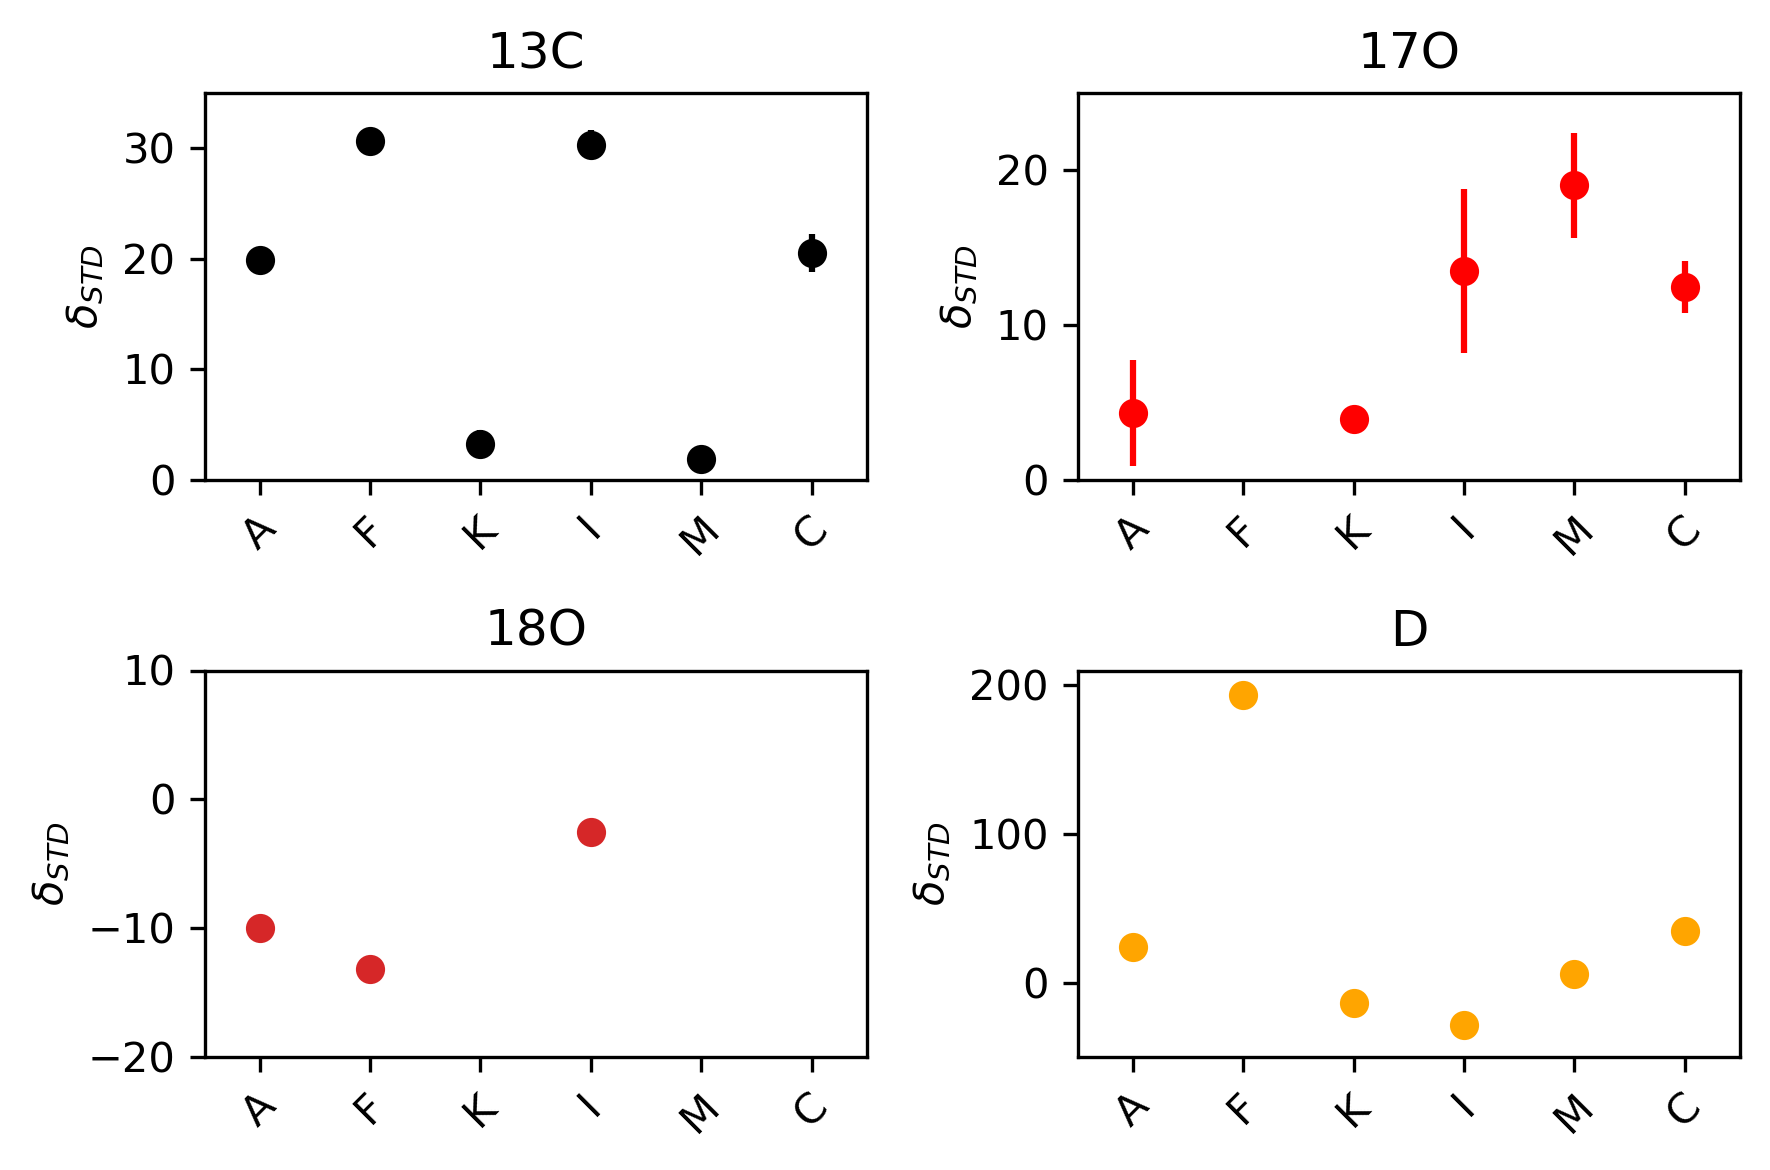

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (6,4), dpi = 300)

i = 0
j = 0

colors = ['k','r','tab:red','orange']
k = 0

ylims = [(0,35),(0,25),(-20,10),(-50, 210)]
for sub, subData in bySubER.items():
    cAx = axes[i,j]
    cAx.errorbar(range(len(subData['Mean'])),subData['Mean'],subData['ER'], fmt = 'o',
                color = colors[k])
    
    cAx.set_title(sub.split('/')[0])
    xticks = [0,1,2,3,4,5]
    #xtickLab = ['Smp M','Smp M','Smp M','Smp I','Smp I','Smp I']
    cAx.set_xticks(xticks)
    cAx.set_xticklabels(MPASample, rotation = 45)
    cAx.set_xlim(-0.5,5.5)
    
    cAx.set_ylabel("$\delta_{STD}$")
    cAx.set_ylim(ylims[k])
    
    #if i == 0 and j == 0:
        #cAx.vlines(2.5,22,22+8.150,label = "Known difference\nbetween A, F")
        #cAx.legend(frameon=False,loc = 'lower right')
    
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1
        
    k += 1
    
plt.tight_layout()